# 이미지 증강
---

In [3]:
# !pip install tensorflow==2.11.0

In [4]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [6]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2023-01-09 07:36:03--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  41.7MB/s    in 6.2s    

2023-01-09 07:36:10 (35.4 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
!tar -xvzf flower_photos.tgz

In [8]:
import pathlib
data_dir = pathlib.Path('/content/flower_photos')
type(data_dir)

pathlib.PosixPath

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
# 모든(*) 데이터파일 안에 있는 jpg 확장자의 모든 파일 읽음
image_count

3670

In [10]:
fnames = list(data_dir.glob('*/*.jpg'))
fnames[0]

PosixPath('/content/flower_photos/sunflowers/5970301989_fe3a68aac8_m.jpg')

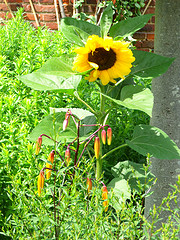

In [11]:
import PIL
import PIL.Image

PIL.Image.open(fnames[0])

## Dataset 객체

In [12]:
image_size = (180,180)
batch_size = 32

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    image_size=image_size,
    batch_size=batch_size,
    seed=2022
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    image_size=image_size,
    batch_size=batch_size,
    seed=2022
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
def build_model_3():
  model = keras.Sequential([
      layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(180,180,3)),
      layers.MaxPool2D(2),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPool2D(2),

      layers.Flatten(),
      layers.Dropout(0.3),
      layers.Dense(256, activation='relu'),
      layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer = 'adam',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['acc']
  )
  return model

In [16]:
model = build_model_3()

log = model.fit(train_ds,
          epochs = 5,
          validation_data = val_ds,
          verbose = 1)

Epoch 1/5
92/92 [==============================] - 18s 79ms/step - loss: 122.4583 - acc: 0.2663 - val_loss: 1.6107 - val_acc: 0.3106
Epoch 2/5
92/92 [==============================] - 7s 70ms/step - loss: 1.3879 - acc: 0.4302 - val_loss: 1.6706 - val_acc: 0.2916
Epoch 3/5
92/92 [==============================] - 8s 86ms/step - loss: 1.1456 - acc: 0.5460 - val_loss: 1.8779 - val_acc: 0.2929
Epoch 4/5
92/92 [==============================] - 8s 79ms/step - loss: 0.9213 - acc: 0.6478 - val_loss: 2.5978 - val_acc: 0.3215
Epoch 5/5
92/92 [==============================] - 7s 69ms/step - loss: 0.7312 - acc: 0.7394 - val_loss: 2.6175 - val_acc: 0.3256


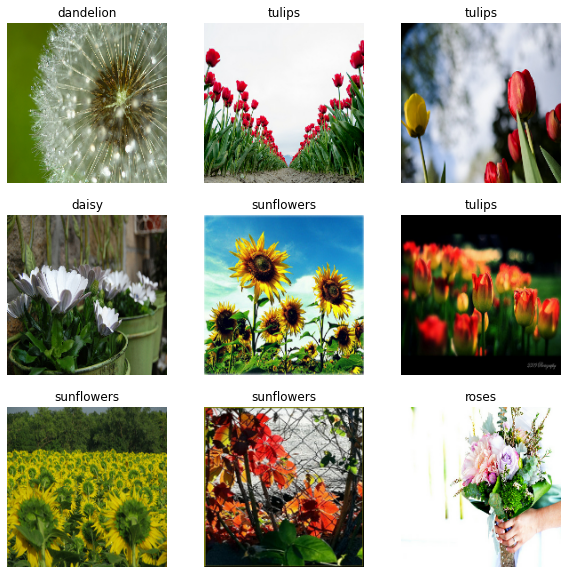

In [21]:
for images, labels in train_ds.take(1):
  # take :: iteate 순서대로 1배치를 나타냄
  # next와 비슷한 기능 (32개 뽑아옴)
  plt.figure(figsize=(10,10))
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('int'))
    # 텐서 -> 넘파이(소수) -> 정수
    plt.title(train_ds.class_names[labels[i]])
    plt.axis('off')
  plt.show()

## 성능을 위한 설정 (캐시)

In [23]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# AUTOTUNE -> PC성능에 맞추어 자동으로 prefetch 캐싱
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 바로 모델에 학습시켜도 됨

## 이미지 증강

In [33]:
data_augmen = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomFlip('vertical'),
    # 랜덤으로 좌우를 fliping
    layers.RandomRotation(0.5)
])

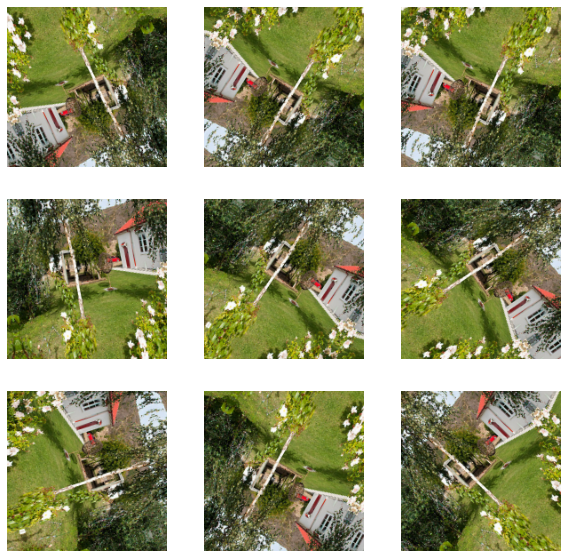

In [34]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  # 랜덤하게 flip, rotation 하여 이미지 생성

  for i in range(9):
    augmented_images = data_augmen(images)
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('int'))
    # 같은 이미지를 여러번 augmen
    plt.axis('off')
  plt.show()

In [48]:
data_augmen = keras.Sequential([
    layers.Rescaling(1./255.),
    layers.Resizing(180,180),
    layers.RandomFlip('horizontal'),
    layers.RandomFlip('vertical'),
    layers.RandomRotation(0.5)
])

train_ds = train_ds.map(
    lambda img, label: (data_augmen(img), label),
    # augmen한 이미지와 기존 데이터의 label 세트가 만들어짐
    num_parallel_calls=tf.data.AUTOTUNE
    # 속도를 빠르게 하기 위해 병렬처리
)

train_ds = train_ds.map(
    lambda img, label: (data_augmen(img), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [49]:
 model = build_model_3()

In [50]:
EPOCHS = 10

log = model.fit(train_ds,
                epochs = EPOCHS,
                validation_data = val_ds,
                verbose = 1)

Epoch 1/10
92/92 [==============================] - 20s 194ms/step - loss: 1.6047 - acc: 0.2408 - val_loss: 3132.2468 - val_acc: 0.3243
Epoch 2/10
92/92 [==============================] - 18s 192ms/step - loss: 1.6019 - acc: 0.2459 - val_loss: 3131.0691 - val_acc: 0.3120
Epoch 3/10
92/92 [==============================] - 18s 193ms/step - loss: 1.6014 - acc: 0.2459 - val_loss: 3150.4700 - val_acc: 0.3188
Epoch 4/10
92/92 [==============================] - 18s 189ms/step - loss: 1.6012 - acc: 0.2459 - val_loss: 3152.3594 - val_acc: 0.3215
Epoch 5/10
92/92 [==============================] - 18s 199ms/step - loss: 1.6009 - acc: 0.2459 - val_loss: 3148.1377 - val_acc: 0.3215
Epoch 6/10
92/92 [==============================] - 18s 193ms/step - loss: 1.6008 - acc: 0.2459 - val_loss: 3156.3604 - val_acc: 0.3202
Epoch 7/10
92/92 [==============================] - 18s 195ms/step - loss: 1.6003 - acc: 0.2459 - val_loss: 3066.7434 - val_acc: 0.3161
Epoch 8/10
92/92 [==============================

In [51]:
model.evaluate(train_ds)

92/92 [==============================] - 21s 207ms/step - loss: 1.5994 - acc: 0.2459


[1.599413275718689, 0.2459128051996231]

In [52]:
model.evaluate(val_ds)

23/23 [==============================] - 0s 15ms/step - loss: 3098.8000 - acc: 0.3120


[3098.800048828125, 0.31198909878730774]